# CTH Image Interpretation

In [1]:
import os

# DWD proxy
os.environ["HTTP_PROXY"]  = "http://ofsquid.dwd.de:8080"
os.environ["HTTPS_PROXY"] = "http://ofsquid.dwd.de:8080"

# Optional but recommended
os.environ["http_proxy"]  = os.environ["HTTP_PROXY"]
os.environ["https_proxy"] = os.environ["HTTPS_PROXY"]

In [2]:
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin

# Step 1: Find the latest CTH file
base_url = "https://opendata.dwd.de/weather/satellite/clouds/CTH/"
response = requests.get(base_url)
soup = BeautifulSoup(response.text, "html.parser")

# List all .nc.bz2 files
cth_files = sorted([
    link.get("href") for link in soup.find_all("a")
    if link.get("href", "").endswith(".nc.bz2")
])

# Use the latest file
latest_file = cth_files[-1]
download_url = urljoin(base_url, latest_file)

# Download the file
filename = "cth_latest.nc.bz2"
with open(filename, "wb") as f:
    f.write(requests.get(download_url).content)

print(f"✅ Downloaded: {latest_file}")


✅ Downloaded: CTHin202512301415.nc.bz2


In [3]:
import bz2

# Decompress downloaded CTH file
with bz2.BZ2File("cth_latest.nc.bz2", "rb") as f_in:
    with open("cth_latest.nc", "wb") as f_out:
        f_out.write(f_in.read())

print("✅ Decompressed cth_latest.nc.bz2 → cth_latest.nc")

✅ Decompressed cth_latest.nc.bz2 → cth_latest.nc


In [4]:
import netCDF4 as nc

ds = nc.Dataset("cth_latest.nc")

print("📦 Variables in file:")
for var in ds.variables:
    print(f" - {var}: {ds.variables[var].shape}")

📦 Variables in file:
 - lat: (934,)
 - lon: (1601,)
 - time: (1,)
 - CTH: (1, 934, 1601)
 - opa: (1, 934, 1601)
 - latlon: ()


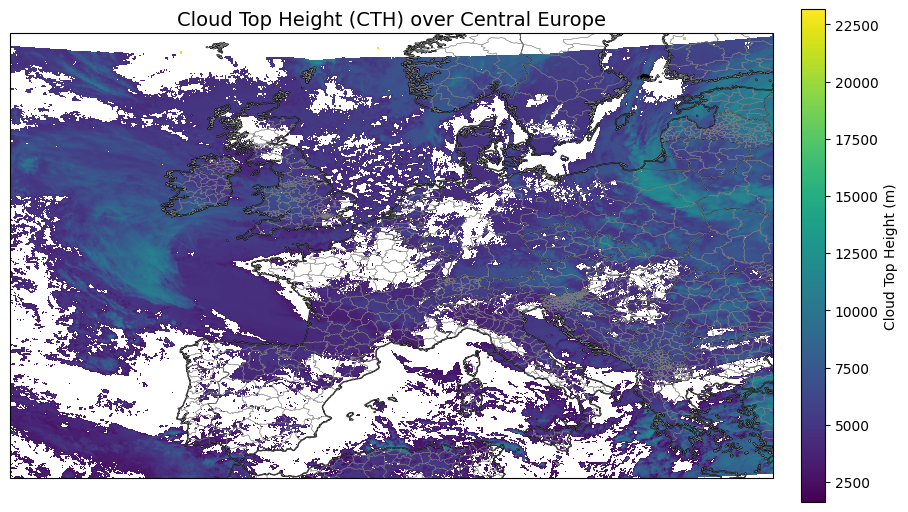

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Read variables
cth = ds.variables["CTH"][0, :, :]  # remove time dimension
lat = ds.variables["lat"][:]
lon = ds.variables["lon"][:]

# Optional: mask missing or invalid values
cth = np.ma.masked_where(cth <= 0, cth)

# Create meshgrid for pcolormesh
lon2d, lat2d = np.meshgrid(lon, lat)

# Set up map with Cartopy
fig = plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([lon.min(), lon.max(), lat.min(), lat.max()], crs=ccrs.PlateCarree())

# Plot data
mesh = ax.pcolormesh(lon2d, lat2d, cth, cmap="viridis", shading="auto", transform=ccrs.PlateCarree())
cbar = plt.colorbar(mesh, orientation='vertical', pad=0.03, shrink=0.8)
cbar.set_label("Cloud Top Height (m)")

# Add features
ax.coastlines(resolution="10m", linewidth=1)
ax.add_feature(cfeature.BORDERS, linewidth=0.6)
ax.add_feature(cfeature.STATES.with_scale("10m"), linewidth=0.3, edgecolor="gray")

# Titles
plt.title("Cloud Top Height (CTH) over Central Europe", fontsize=14)

# Save and show
plt.savefig("cth_map.png", dpi=150, bbox_inches='tight')
plt.show()

In [6]:
from openai import OpenAI
from dotenv import load_dotenv
import os
import base64
from IPython.display import Markdown, display

# Load API key from .env file
load_dotenv()
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

# Read and encode the image
with open("cth_map.png", "rb") as image_file:
    base64_image = base64.b64encode(image_file.read()).decode("utf-8")

# Create the vision-enabled prompt
response = client.chat.completions.create(
    model="gpt-4-turbo",
    messages=[
        {
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": (
                    "This is a satellite-derived Cloud Top Height (CTH) image over Europe."
                        "Please interpret the structure shown in the image: \n"
                        "- Identify regions of high or low cloud tops.\n"
                        "- Estimate where deep convection may be present.\n"
                        "- Describe what synoptic or convective features are visible.\n"
                        "- Provide a summary of the possible weather situation."
                    )
                },
                {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/png;base64,{base64_image}"
                    }
                }
            ]
        }
    ],
    max_tokens=800,
)

# Display the response as markdown
interpretation = response.choices[0].message.content
display(Markdown(interpretation))

This satellite image of Cloud Top Height (CTH) shows the distribution and height of cloud tops over Europe. The color scale on the right indicates the height of cloud tops in meters, ranging from 2500 meters (dark purple) to 22500 meters (yellow).

**Identification of High and Low Cloud Tops:**
- **High Cloud Tops:** Regions exhibiting yellow and green colors suggest very high cloud tops, likely above 17500 meters. These are primarily seen in the areas towards the southwestern part (possibly over the Atlantic Ocean near Portugal and Spain) and scattered through Central Europe, possibly extending towards parts of eastern Europe.
- **Low Cloud Tops:** Dark purple areas depict very low cloud tops, around 2500 meters or less. These are seen widely over the ocean in the southwest and scattered throughout the mainland Europe including what looks like the northern parts of Scandinavia and eastern parts of Europe.

**Estimation of Deep Convection:**
- Areas with yellow indicating very high cloud tops are typically suggestive of deep convection. These could be associated with thunderstorms or severe weather systems. Notably, the patches toward the southwestern edge of the map (near Iberian Peninsula) could be an indication of such weather events.

**Description of Synoptic and Convective Features:**
- The distribution of cloud tops in this image indicates a variety of weather systems. The higher cloud tops over the ocean and scattered through Europe suggest the presence of more intense weather systems, possibly including frontal systems and convective storms.
- Lower cloud tops, especially widespread in central and eastern Europe, could be indicative of more stable weather or presence of stratiform clouds, generally associated with less severe weather.

**Summary of Possible Weather Situation:**
Given the satellite imagery analysis:
- The western and southwestern regions of Europe may be experiencing active and possibly severe weather systems with potential thunderstorms or frontal storms, indicated by high CTH.
- Central and Eastern Europe show predominantly lower cloud tops indicating potentially calmer weather conditions, possibly with colder air masses since these regions typically have less solar heating during this period.
- The overall synoptic situation suggests a mixed weather pattern across Europe, with potential for precipitation, varying temperatures, and wind patterns influenced by the positioning and movement of these cloud systems.

This interpretation aligns with typical synoptic scale weather processes, where high CTH often correlates with more dynamic and potentially unsettled weather patterns, while lower CTH can indicate more stable atmospheric conditions.